## 1. Import and Setup

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from skimage.feature import local_binary_pattern
from collections import Counter
from PIL import Image
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Loading Dataset Paths and Basic Info

In [5]:
base_path = r'C:\Users\param\Downloads\archive\MY_data'
train_path = os.path.join(base_path, 'train')
class_names = os.listdir(train_path)

image_paths = []
labels = []

for i, class_name in enumerate(class_names):
    class_folder = os.path.join(train_path, class_name)
    for img_file in os.listdir(class_folder):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(class_folder, img_file))
            labels.append(i)

print("Classes:", class_names)
print("Total Images:", len(image_paths))
print("Total Classes:", len(class_names))


Classes: ['Apple', 'avocado', 'Banana', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Total Images: 2301
Total Classes: 10


## 3. Image Size Statistics

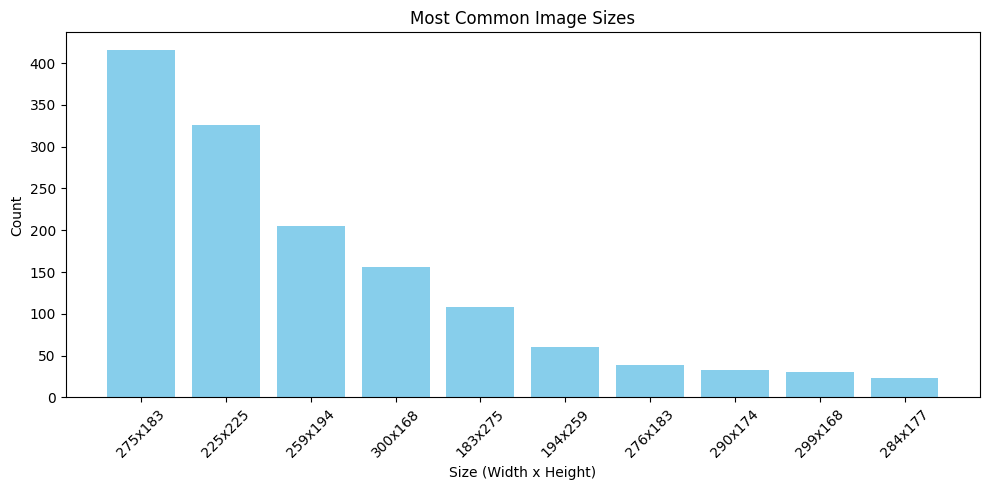

In [6]:
sizes = []
for path in image_paths:
    img = Image.open(path)
    sizes.append(img.size)

size_counts = Counter(sizes)
sorted_sizes = sorted(size_counts.items(), key=lambda x: x[1], reverse=True)

most_common_sizes = sorted_sizes[:10]
sizes_str = [f"{w}x{h}" for (w, h), _ in most_common_sizes]
counts = [count for _, count in most_common_sizes]

plt.figure(figsize=(10, 5))
plt.bar(sizes_str, counts, color='skyblue')
plt.title("Most Common Image Sizes")
plt.xlabel("Size (Width x Height)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Resize All Images to 128x128 using TensorFlow

In [7]:
import tensorflow as tf
import numpy as np

# Target size
TARGET_SIZE = (128, 128)

# Function to load and resize images
def load_and_resize_images(image_paths, target_size=TARGET_SIZE):
    resized_images = []
    for path in image_paths:
        try:
            # Load image
            img = tf.keras.utils.load_img(path, target_size=target_size)
            img_array = tf.keras.utils.img_to_array(img)
            resized_images.append(img_array)
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            continue
    return np.array(resized_images)

# Apply resizing
resized_images = load_and_resize_images(image_paths)

print("Resized image array shape:", resized_images.shape)


Resized image array shape: (2301, 128, 128, 3)


## 4. Class-wise Image Count Bar Plot

C:\Users\param\AppData\Local\Temp\ipykernel_17644\4267319901.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=[class_counts[i] for i in range(len(class_names))], palette='Set2')


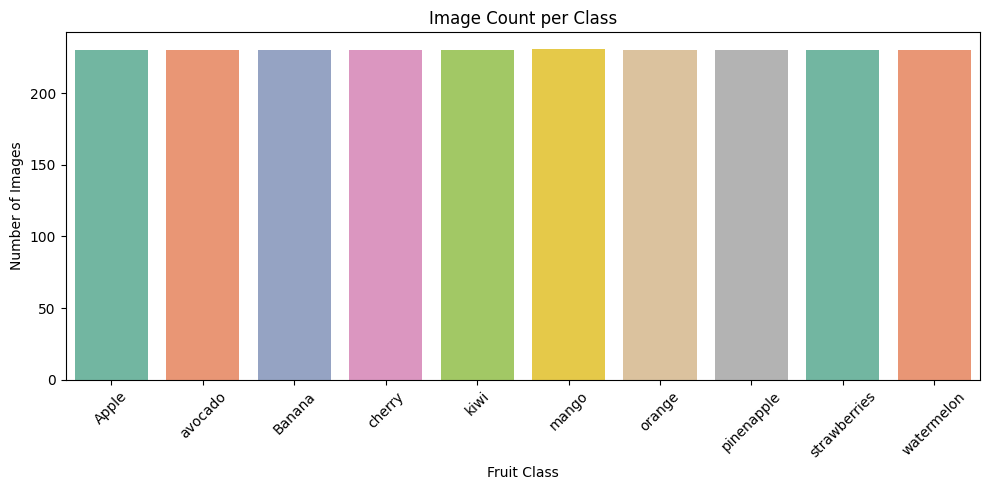

In [8]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Count images per class
class_counts = Counter(labels)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=[class_counts[i] for i in range(len(class_names))], palette='Set2')
plt.title("Image Count per Class")
plt.xlabel("Fruit Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Flattening Images for PCA

In [9]:
# Convert RGB images to grayscale and flatten
def flatten_resized_images(images):
    gray_images = tf.image.rgb_to_grayscale(images).numpy()
    flat = gray_images.reshape((gray_images.shape[0], -1))
    return flat

flat_features = flatten_resized_images(resized_images)
print("Flat feature shape:", flat_features.shape)


Flat feature shape: (2301, 16384)


## 6. PCA Visualization

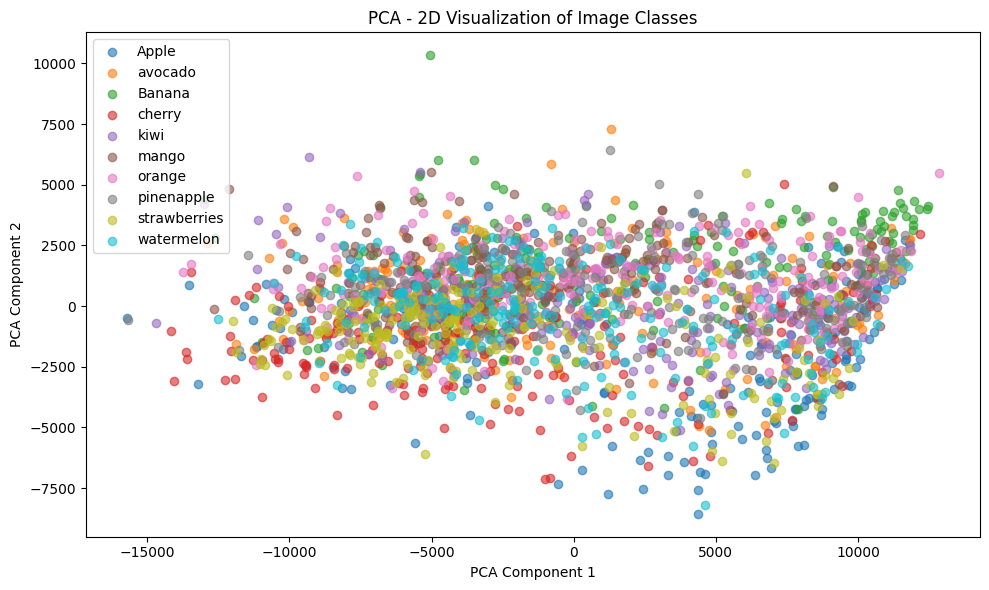

In [10]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flat_features)

# Plot PCA result
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(class_names):
    idxs = [j for j, lbl in enumerate(labels[:len(pca_result)]) if lbl == i]
    plt.scatter(pca_result[idxs, 0], pca_result[idxs, 1], label=class_name, alpha=0.6)

plt.title("PCA - 2D Visualization of Image Classes")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.tight_layout()
plt.show()


## 7. Blur Detection using Laplacian Variance

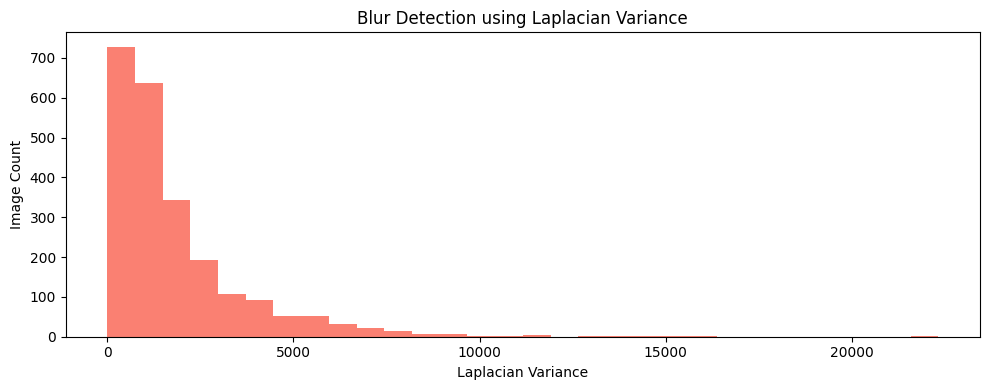

In [11]:
def detect_blur(image_paths):
    blur_scores = []
    for path in image_paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
        blur_scores.append(laplacian_var)
    return blur_scores

blur_scores = detect_blur(image_paths)

# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(blur_scores, bins=30, color='salmon')
plt.title("Blur Detection using Laplacian Variance")
plt.xlabel("Laplacian Variance")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

## 8. Image Augmentation using TensorFlow’s ImageDataGenerator

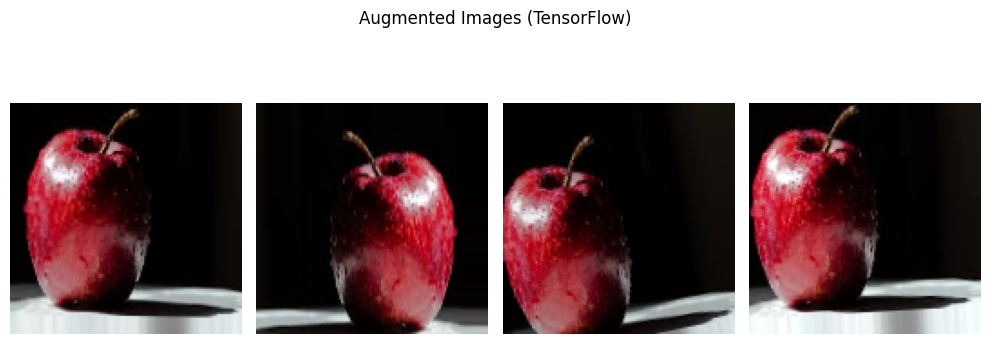

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create a generator with basic augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

# Pick one image to demonstrate
sample_image = resized_images[0].reshape((1, 128, 128, 3))

# Generate augmented versions
aug_iter = datagen.flow(sample_image, batch_size=1)

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    batch = next(aug_iter)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
plt.suptitle("Augmented Images (TensorFlow)")
plt.tight_layout()
plt.show()


## 9. Texture Feature Extraction using LBP
 

In [13]:
from skimage.feature import local_binary_pattern

def extract_lbp_features_from_resized(images):
    lbp_features = []
    for img in images:
        gray = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 27), range=(0, 26))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_features.append(hist)
    return np.array(lbp_features)

lbp_feats = extract_lbp_features_from_resized(resized_images)
print("Extracted LBP feature shape:", lbp_feats.shape)

Extracted LBP feature shape: (2301, 26)
